# Euler Flow Around a Rectangle

## Project Overview
This notebook simulates **inviscid (Euler) flow** around a rectangular obstacle in a 2D domain. 

### Learning Objectives:
- Understand the Euler equations for inviscid flow
- Implement boundary conditions for obstacles
- Visualize flow patterns (velocity field, pressure, streamlines)
- Learn about numerical stability in CFD

### Physics: 2D Euler Equations

For inviscid, incompressible flow, we solve:

**Continuity equation (mass conservation):**
$$\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0$$

**Momentum equations (Euler equations - no viscosity):**
$$\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} + v\frac{\partial u}{\partial y} = -\frac{1}{\rho}\frac{\partial p}{\partial x}$$

$$\frac{\partial v}{\partial t} + u\frac{\partial v}{\partial x} + v\frac{\partial v}{\partial y} = -\frac{1}{\rho}\frac{\partial p}{\partial y}$$

Where:
- $u, v$ = velocity components in x, y directions
- $p$ = pressure
- $\rho$ = density (constant for incompressible flow)

In [15]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

## 1. Domain Setup

We'll create a rectangular computational domain with a rectangular obstacle in the center.

In [16]:
# Domain parameters
Lx = 4.0      # Domain length in x-direction (m)
Ly = 2.0      # Domain length in y-direction (m)
nx = 161      # Number of grid points in x
ny = 81       # Number of grid points in y

dx = Lx / (nx - 1)
dy = Ly / (ny - 1)

# Create mesh
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
X, Y = np.meshgrid(x, y)

# Rectangular obstacle dimensions
rect_x_start = 1.5  # Start position of rectangle in x
rect_x_end = 2.0    # End position of rectangle in x
rect_y_start = 0.75 # Start position of rectangle in y
rect_y_end = 1.25   # End position of rectangle in y

# Create mask for the obstacle (True where fluid can flow, False for solid)
fluid_mask = np.ones((ny, nx), dtype=bool)

for i in range(ny):
    for j in range(nx):
        if (rect_x_start <= x[j] <= rect_x_end and 
            rect_y_start <= y[i] <= rect_y_end):
            fluid_mask[i, j] = False

print(f"Grid size: {nx} x {ny}")
print(f"Grid spacing: dx = {dx:.4f}, dy = {dy:.4f}")
print(f"Rectangle position: x=[{rect_x_start}, {rect_x_end}], y=[{rect_y_start}, {rect_y_end}]")

Grid size: 161 x 81
Grid spacing: dx = 0.0250, dy = 0.0250
Rectangle position: x=[1.5, 2.0], y=[0.75, 1.25]


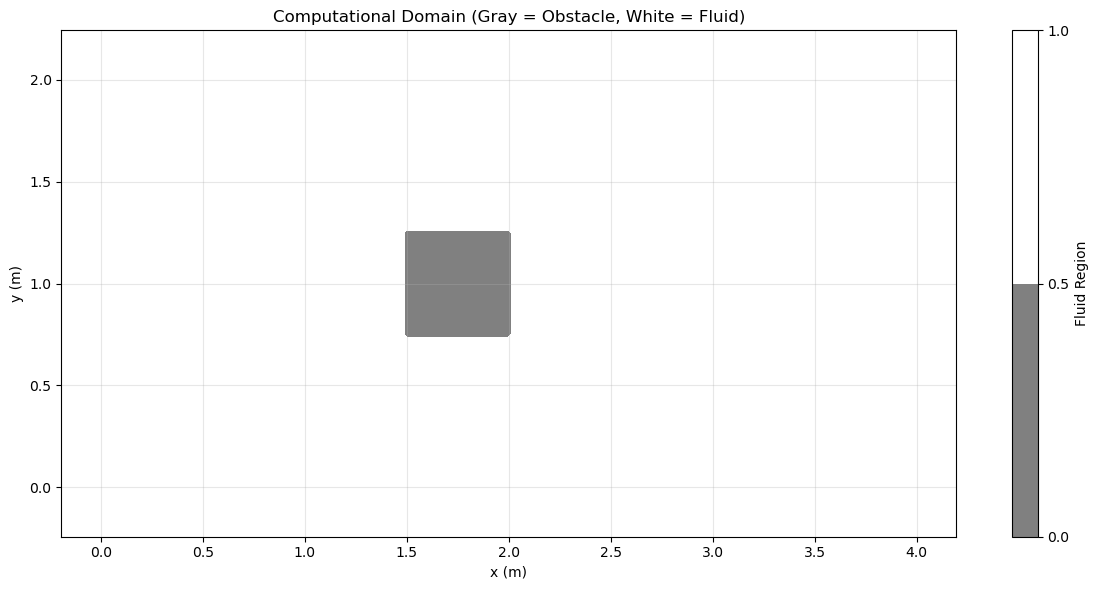

In [17]:
# Visualize the domain and obstacle
plt.figure(figsize=(12, 6))
plt.contourf(X, Y, fluid_mask.astype(int), levels=[0, 0.5, 1], colors=['gray', 'white'])
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Computational Domain (Gray = Obstacle, White = Fluid)')
plt.colorbar(label='Fluid Region')
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 2. Initial Conditions

Set up initial flow conditions:
- Uniform flow from left to right
- Zero initial pressure gradient

In [18]:
# Flow parameters
U_inf = 1.0    # Free-stream velocity (m/s)
rho = 1.0      # Density (kg/m^3)

# Initialize velocity and pressure fields
u = np.ones((ny, nx)) * U_inf  # x-velocity
v = np.zeros((ny, nx))          # y-velocity
p = np.zeros((ny, nx))          # pressure

# Set velocity to zero inside the obstacle
u[~fluid_mask] = 0.0
v[~fluid_mask] = 0.0

print("Initial conditions set:")
print(f"  Free-stream velocity: {U_inf} m/s")
print(f"  Density: {rho} kg/m^3")

Initial conditions set:
  Free-stream velocity: 1.0 m/s
  Density: 1.0 kg/m^3


## 3. Boundary Conditions

Define boundary conditions:
- **Inlet (left)**: Fixed velocity $u = U_{\infty}$, $v = 0$
- **Outlet (right)**: Zero gradient (Neumann)
- **Top/Bottom walls**: Slip conditions (free-slip) or periodic
- **Obstacle surface**: No-penetration (velocity normal to surface = 0)

In [19]:
def apply_boundary_conditions(u, v, p, fluid_mask):
    """
    Apply boundary conditions to the flow field.
    
    Parameters:
    -----------
    u, v : velocity components
    p : pressure
    fluid_mask : boolean array (True for fluid, False for solid)
    """
    # Inlet (left boundary): fixed velocity
    u[:, 0] = U_inf
    v[:, 0] = 0.0
    
    # Outlet (right boundary): zero gradient
    u[:, -1] = u[:, -2]
    v[:, -1] = v[:, -2]
    p[:, -1] = p[:, -2]
    
    # Top and bottom boundaries: slip condition (du/dy = 0, v = 0)
    u[0, :] = u[1, :]
    u[-1, :] = u[-2, :]
    v[0, :] = 0.0
    v[-1, :] = 0.0
    
    # Obstacle: enforce no-penetration by setting velocity to zero
    # This creates a solid boundary where fluid cannot enter
    u[~fluid_mask] = 0.0
    v[~fluid_mask] = 0.0
    
    return u, v, p

## 4. Numerical Solver

We'll use a simplified approach combining:
1. **Explicit time-stepping** for momentum equations
2. **Pressure projection method** to ensure incompressibility

### Algorithm (Chorin's Projection Method):
1. Compute intermediate velocity (ignoring pressure)
2. Solve pressure Poisson equation to enforce continuity
3. Correct velocity field using pressure gradient

### Important Implementation Notes:

**Key improvements for numerical stability and accuracy:**

1. **Upwind scheme**: Uses upwind differencing for convection terms based on flow direction. This prevents numerical instabilities common with central differencing in advection-dominated flows.

2. **Obstacle boundary treatment**: 
   - Velocity is enforced to zero inside obstacle
   - Pressure uses Neumann boundary condition (zero gradient normal to surface)
   - Only fluid cells are updated during velocity advancement

3. **Chorin's Projection Method**:
   - Step 1: Advance velocity without pressure (intermediate velocity)
   - Step 2: Solve Poisson equation for pressure to enforce incompressibility
   - Step 3: Correct velocity using pressure gradient

4. **Mass conservation**: The divergence of velocity should remain close to zero throughout the simulation, which we monitor.

In [20]:
def pressure_poisson(p, u, v, dx, dy, dt, fluid_mask, nit=50):
    """
    Solve the pressure Poisson equation using iterative method.
    
    ∇²p = ρ/dt * (∂u/∂x + ∂v/∂y)
    """
    pn = p.copy()
    
    for _ in range(nit):
        pn = p.copy()
        
        # Compute divergence of velocity field
        b = np.zeros_like(p)
        b[1:-1, 1:-1] = (rho / dt * 
                        ((u[1:-1, 2:] - u[1:-1, :-2]) / (2 * dx) +
                         (v[2:, 1:-1] - v[:-2, 1:-1]) / (2 * dy)))
        
        # Iterative solver for Poisson equation (Jacobi method)
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, :-2]) * dy**2 +
                          (pn[2:, 1:-1] + pn[:-2, 1:-1]) * dx**2) /
                         (2 * (dx**2 + dy**2)) -
                         dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * b[1:-1, 1:-1])
        
        # Boundary conditions for pressure
        p[:, -1] = p[:, -2]  # dp/dx = 0 at outlet
        p[:, 0] = p[:, 1]    # dp/dx = 0 at inlet
        p[0, :] = p[1, :]    # dp/dy = 0 at bottom
        p[-1, :] = p[-2, :]  # dp/dy = 0 at top
        
        # Neumann BC at obstacle surface: dp/dn = 0
        # Use neighboring fluid cell values for pressure at obstacle
        for i in range(1, ny-1):
            for j in range(1, nx-1):
                if not fluid_mask[i, j]:
                    # Average pressure from neighboring fluid cells
                    count = 0
                    p_avg = 0.0
                    if fluid_mask[i+1, j]:
                        p_avg += pn[i+1, j]
                        count += 1
                    if fluid_mask[i-1, j]:
                        p_avg += pn[i-1, j]
                        count += 1
                    if fluid_mask[i, j+1]:
                        p_avg += pn[i, j+1]
                        count += 1
                    if fluid_mask[i, j-1]:
                        p_avg += pn[i, j-1]
                        count += 1
                    if count > 0:
                        p[i, j] = p_avg / count
    
    return p

In [27]:
def euler_step(u, v, p, dt, dx, dy, fluid_mask):
    """
    Perform one time step of the Euler flow solver using Chorin's projection method.
    """
    un = u.copy()
    vn = v.copy()
    
    # Step 1: Compute intermediate velocity (advection step without pressure)
    # Using upwind scheme for stability
    # du/dt = -u*du/dx - v*du/dy
    for i in range(1, ny-1):
        for j in range(1, nx-1):
            if fluid_mask[i, j]:  # Only update fluid cells
                # Upwind differencing for convection terms
                if un[i, j] > 0:
                    dudx = (un[i, j] - un[i, j-1]) / dx
                else:
                    dudx = (un[i, j+1] - un[i, j]) / dx
                    
                if vn[i, j] > 0:
                    dudy = (un[i, j] - un[i-1, j]) / dy
                else:
                    dudy = (un[i+1, j] - un[i, j]) / dy
                
                u[i, j] = un[i, j] - dt * (un[i, j] * dudx + vn[i, j] * dudy)
    
    # dv/dt = -u*dv/dx - v*dv/dy
    for i in range(1, ny-1):
        for j in range(1, nx-1):
            if fluid_mask[i, j]:  # Only update fluid cells
                # Upwind differencing for convection terms
                if un[i, j] > 0:
                    dvdx = (vn[i, j] - vn[i, j-1]) / dx
                else:
                    dvdx = (vn[i, j+1] - vn[i, j]) / dx
                    
                if vn[i, j] > 0:
                    dvdy = (vn[i, j] - vn[i-1, j]) / dy
                else:
                    dvdy = (vn[i+1, j] - vn[i, j]) / dy
                
                v[i, j] = vn[i, j] - dt * (un[i, j] * dvdx + vn[i, j] * dvdy)
    
    # Apply boundary conditions
    u, v, p = apply_boundary_conditions(u, v, p, fluid_mask)
    
    # Step 2: Solve pressure Poisson equation to enforce incompressibility
    p = pressure_poisson(p, u, v, dx, dy, dt, fluid_mask, nit=50)
    
    # Step 3: Correct velocity with pressure gradient (projection step)
    for i in range(1, ny-1):
        for j in range(1, nx-1):
            if fluid_mask[i, j]:  # Only update fluid cells
                u[i, j] = u[i, j] - dt / rho * (p[i, j+1] - p[i, j-1]) / (2 * dx)
                v[i, j] = v[i, j] - dt / rho * (p[i+1, j] - p[i-1, j]) / (2 * dy)
    
    # Apply boundary conditions again
    u, v, p = apply_boundary_conditions(u, v, p, fluid_mask)
    
    return u, v, p

## 5. Time Integration and Simulation

Run the simulation with proper time-stepping based on CFL condition.

In [26]:
def check_divergence(u, v, dx, dy, fluid_mask):
    """
    Calculate the divergence of the velocity field.
    
    Divergence = ∂u/∂x + ∂v/∂y
    
    For incompressible flow, divergence should be near zero.
    
    Parameters:
    -----------
    u, v : velocity components
    dx, dy : grid spacing
    fluid_mask : boolean array (True for fluid, False for solid)
    
    Returns:
    --------
    div : divergence field
    max_div : maximum divergence in fluid region
    mean_div : mean divergence in fluid region
    """
    div = np.zeros_like(u)
    
    # Calculate divergence using central differences
    div[1:-1, 1:-1] = ((u[1:-1, 2:] - u[1:-1, :-2]) / (2 * dx) +
                       (v[2:, 1:-1] - v[:-2, 1:-1]) / (2 * dy))
    
    # Only consider divergence in fluid cells
    div_fluid = np.abs(div[fluid_mask])
    
    if len(div_fluid) > 0:
        max_div = np.max(div_fluid)
        mean_div = np.mean(div_fluid)
    else:
        max_div = 0.0
        mean_div = 0.0
    
    return div, max_div, mean_div


In [22]:
# Time parameters
dt = 0.001  # Time step (s)
nt = 500    # Number of time steps
t_total = dt * nt

# CFL condition check
CFL = U_inf * dt / dx
print(f"CFL number: {CFL:.4f} (should be < 1.0 for stability)")
print(f"Total simulation time: {t_total:.3f} s")
print(f"Number of time steps: {nt}")

if CFL >= 1.0:
    print("\nWARNING: CFL condition violated! Simulation may be unstable.")
    print(f"Recommended dt < {dx / U_inf:.6f}")

CFL number: 0.0400 (should be < 1.0 for stability)
Total simulation time: 0.500 s
Number of time steps: 500


In [23]:
# Storage for results at different times
save_interval = 100  # Save every N time steps
u_history = []
v_history = []
p_history = []
time_points = []

# Time-stepping loop
print("Starting simulation...")
for n in range(nt):
    u, v, p = euler_step(u, v, p, dt, dx, dy, fluid_mask)
    
    # Save results periodically
    if n % save_interval == 0:
        u_history.append(u.copy())
        v_history.append(v.copy())
        p_history.append(p.copy())
        time_points.append(n * dt)
        print(f"Step {n}/{nt} (t = {n*dt:.4f} s)")

print("Simulation complete!")

Starting simulation...
Step 0/500 (t = 0.0000 s)
Step 100/500 (t = 0.1000 s)
Step 200/500 (t = 0.2000 s)
Step 300/500 (t = 0.3000 s)
Step 400/500 (t = 0.4000 s)
Simulation complete!


Starting simulation...
Step 0/500 (t = 0.0000 s) - Max div: 3.443107e+00
Step 100/500 (t = 0.1000 s) - Max div: 3.376543e+00
Step 200/500 (t = 0.2000 s) - Max div: 3.309211e+00
Step 300/500 (t = 0.3000 s) - Max div: 3.236090e+00
Step 400/500 (t = 0.4000 s) - Max div: 3.159978e+00
Simulation complete!


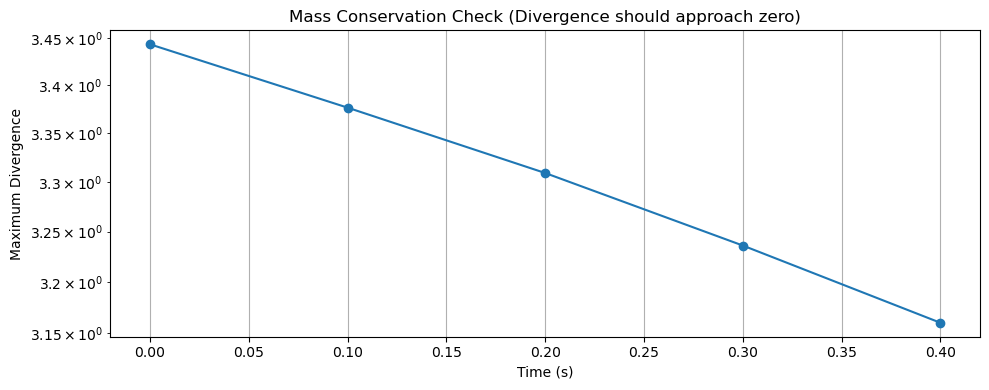

In [28]:
# Storage for results at different times
save_interval = 100  # Save every N time steps
u_history = []
v_history = []
p_history = []
time_points = []
divergence_history = []

# Time-stepping loop
print("Starting simulation...")
for n in range(nt):
    u, v, p = euler_step(u, v, p, dt, dx, dy, fluid_mask)
    
    # Save results periodically
    if n % save_interval == 0:
        u_history.append(u.copy())
        v_history.append(v.copy())
        p_history.append(p.copy())
        time_points.append(n * dt)
        
        # Check divergence
        div, max_div, mean_div = check_divergence(u, v, dx, dy, fluid_mask)
        divergence_history.append(max_div)
        
        print(f"Step {n}/{nt} (t = {n*dt:.4f} s) - Max div: {max_div:.6e}")

print("Simulation complete!")

# Plot divergence history
plt.figure(figsize=(10, 4))
plt.plot(time_points, divergence_history, 'o-')
plt.xlabel('Time (s)')
plt.ylabel('Maximum Divergence')
plt.title('Mass Conservation Check (Divergence should approach zero)')
plt.grid(True)
plt.yscale('log')
plt.tight_layout()
plt.show()

## 6. Visualization

Visualize the results: velocity field, pressure field, and streamlines.

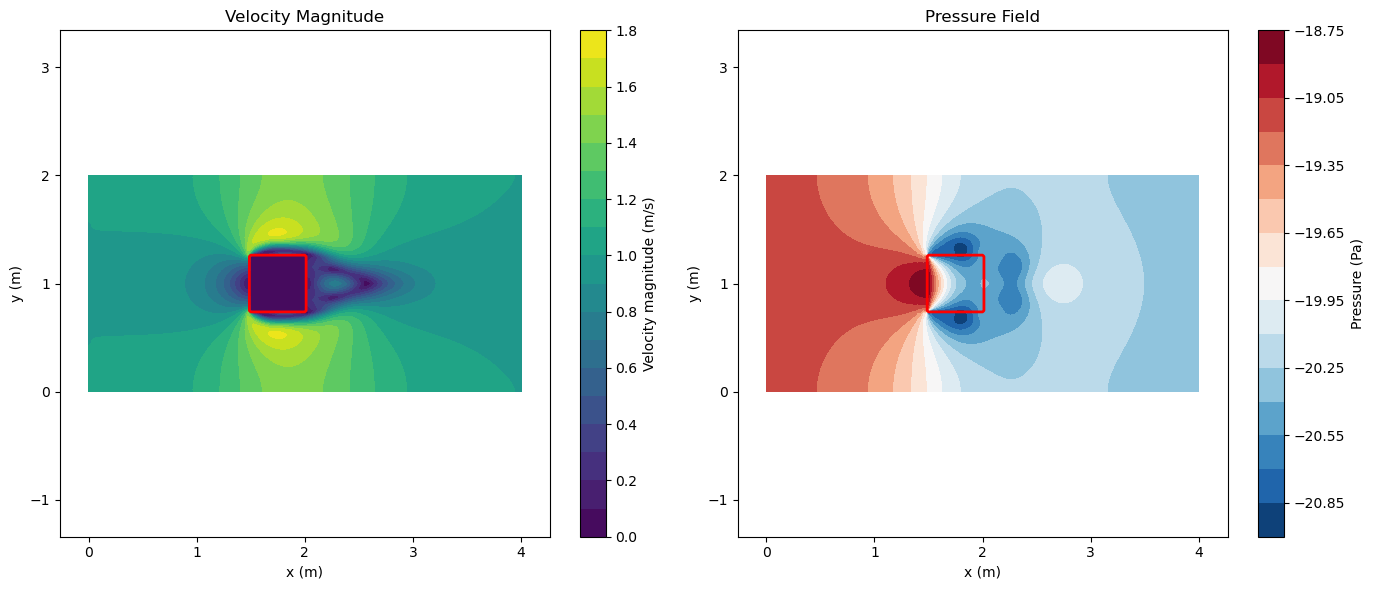

In [29]:
# Plot final velocity magnitude
velocity_magnitude = np.sqrt(u**2 + v**2)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
contour = plt.contourf(X, Y, velocity_magnitude, levels=20, cmap='viridis')
plt.colorbar(contour, label='Velocity magnitude (m/s)')
plt.contour(X, Y, fluid_mask.astype(int), levels=[0.5], colors='red', linewidths=2)
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Velocity Magnitude')
plt.axis('equal')

plt.subplot(1, 2, 2)
contour = plt.contourf(X, Y, p, levels=20, cmap='RdBu_r')
plt.colorbar(contour, label='Pressure (Pa)')
plt.contour(X, Y, fluid_mask.astype(int), levels=[0.5], colors='red', linewidths=2)
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Pressure Field')
plt.axis('equal')

plt.tight_layout()
plt.show()

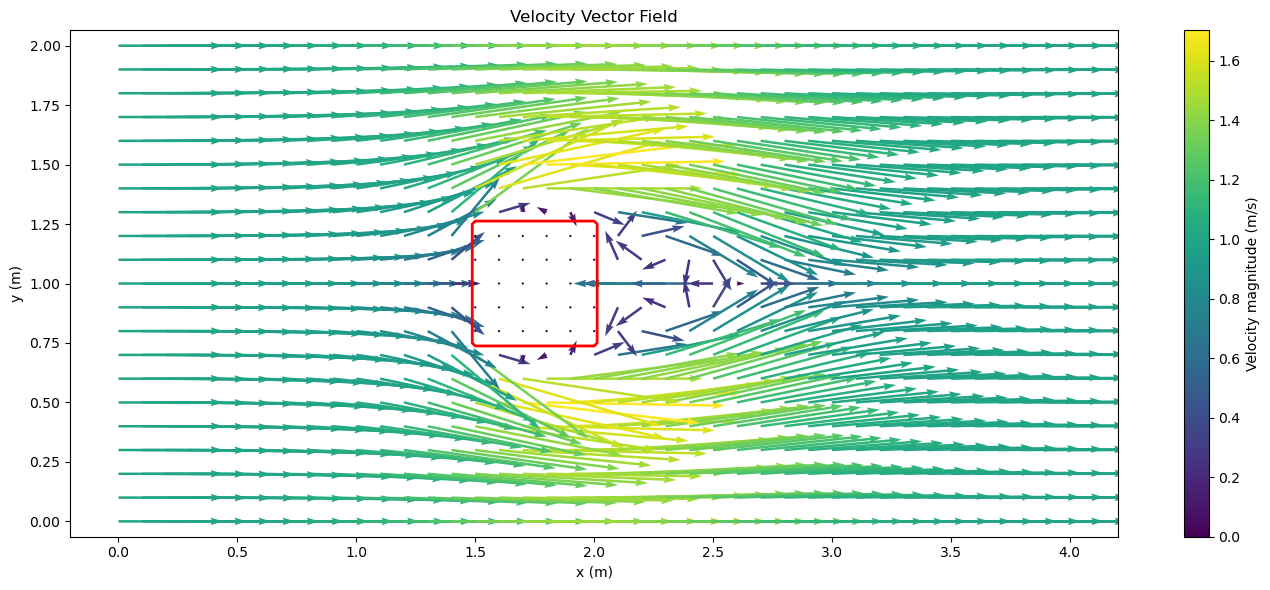

In [30]:
# Plot velocity vectors (quiver plot)
plt.figure(figsize=(14, 6))

# Subsample for clearer visualization
step = 4
plt.quiver(X[::step, ::step], Y[::step, ::step], 
           u[::step, ::step], v[::step, ::step],
           velocity_magnitude[::step, ::step],
           cmap='viridis', scale=10)
plt.colorbar(label='Velocity magnitude (m/s)')
plt.contour(X, Y, fluid_mask.astype(int), levels=[0.5], colors='red', linewidths=2)
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Velocity Vector Field')
plt.axis('equal')
plt.tight_layout()
plt.show()

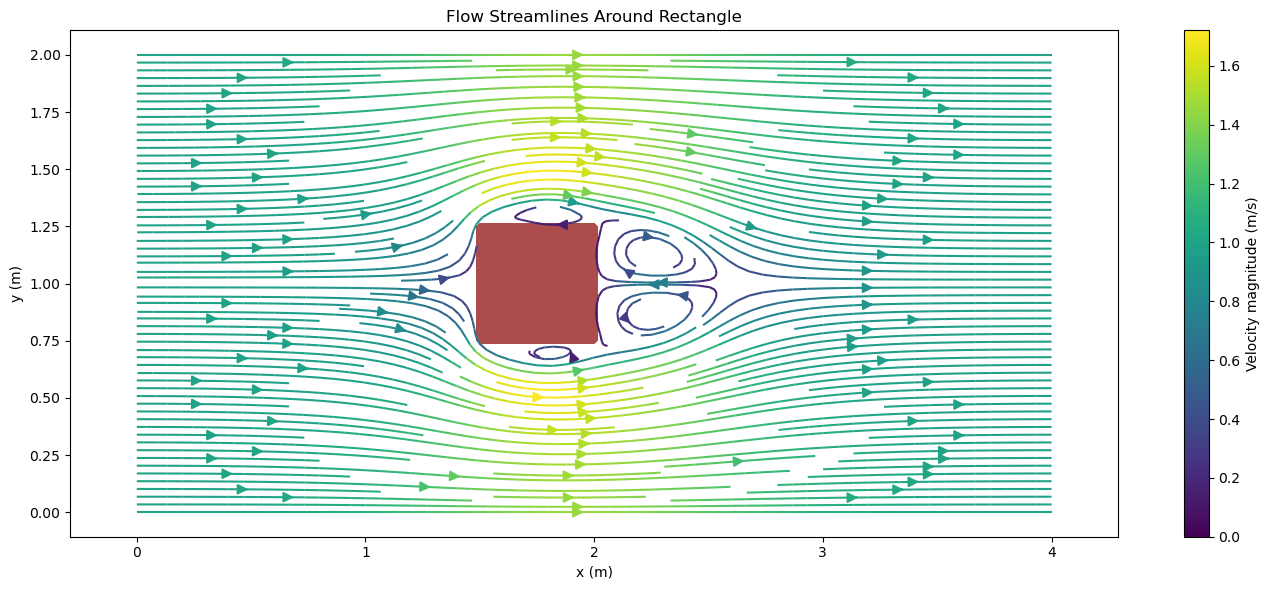

In [31]:
# Plot streamlines
plt.figure(figsize=(14, 6))

# Create streamplot
plt.streamplot(X, Y, u, v, color=velocity_magnitude, 
               linewidth=1.5, cmap='viridis', density=2, arrowsize=1.5)
plt.colorbar(label='Velocity magnitude (m/s)')

# Draw obstacle
obstacle_contour = plt.contourf(X, Y, (~fluid_mask).astype(int), 
                                levels=[0.5, 1.5], colors=['darkred'], alpha=0.7)

plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Flow Streamlines Around Rectangle')
plt.axis('equal')
plt.tight_layout()
plt.show()

## 7. Analysis

Analyze key flow characteristics.

In [32]:
# Calculate drag coefficient (simplified approach)
# Integrate pressure on obstacle surface

# Find obstacle boundaries
obstacle_cells = ~fluid_mask

# Calculate pressure coefficient: Cp = (p - p_inf) / (0.5 * rho * U_inf^2)
p_inf = 0.0  # Reference pressure
Cp = (p - p_inf) / (0.5 * rho * U_inf**2)

print("Flow Analysis:")
print(f"Maximum velocity: {velocity_magnitude.max():.4f} m/s")
print(f"Minimum velocity: {velocity_magnitude[fluid_mask].min():.4f} m/s")
print(f"Maximum pressure: {p.max():.4f} Pa")
print(f"Minimum pressure: {p.min():.4f} Pa")
print(f"Maximum Cp: {Cp.max():.4f}")
print(f"Minimum Cp: {Cp.min():.4f}")

Flow Analysis:
Maximum velocity: 1.7207 m/s
Minimum velocity: 0.0013 m/s
Maximum pressure: -18.8081 Pa
Minimum pressure: -20.9526 Pa
Maximum Cp: -37.6161
Minimum Cp: -41.9052


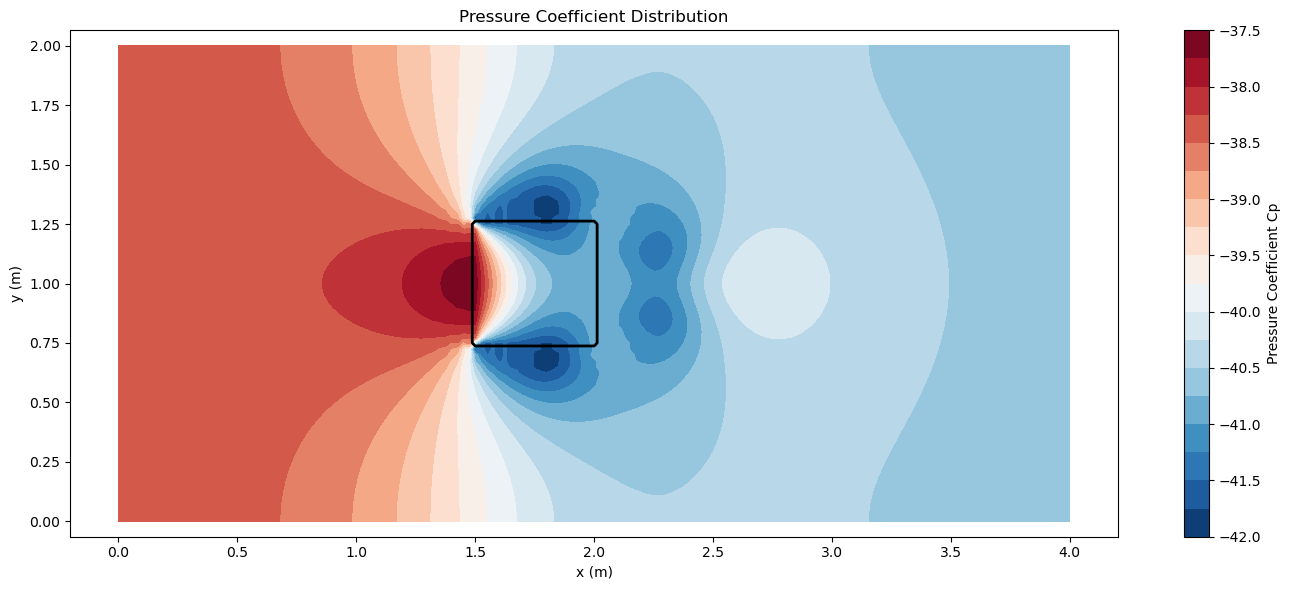

In [34]:
# Plot pressure coefficient
plt.figure(figsize=(14, 6))
contour = plt.contourf(X, Y, Cp, levels=20, cmap='RdBu_r')
plt.colorbar(contour, label='Pressure Coefficient Cp')
plt.contour(X, Y, fluid_mask.astype(int), levels=[0.5], colors='black', linewidths=2)
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Pressure Coefficient Distribution')
plt.axis('equal')
plt.tight_layout()
plt.show()

## 8. Exercises and Extensions

Try modifying the code to explore different scenarios:

1. **Change obstacle shape**: Try circular, elliptical, or airfoil shapes
2. **Vary Reynolds number**: Add viscosity terms (transition to Navier-Stokes)
3. **Different boundary conditions**: Try different inlet velocities or angles
4. **Grid refinement study**: Increase nx, ny to see convergence
5. **Multiple obstacles**: Add more rectangles or different shapes
6. **Time evolution**: Create animation showing flow development
7. **Vortex shedding**: For higher Reynolds numbers, observe vortex formation (requires Navier-Stokes)

### Additional Metrics to Calculate:
- Drag and lift forces on the obstacle
- Circulation around the obstacle
- Mass flux conservation check
- Energy dissipation

## 9. References and Further Reading

- Anderson, J. D. (2011). *Fundamentals of Aerodynamics*. McGraw-Hill.
- Chorin, A. J. (1968). "Numerical solution of the Navier-Stokes equations." *Mathematics of Computation*.
- Barba, L. A., & Forsyth, G. F. (2018). "CFD Python: 12 steps to Navier-Stokes."
- Computational Fluid Dynamics textbook by Anderson, Tannehill, and Pletcher